<div class="title">Practical Assignment: Support Vector Machines</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [432]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [433]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [434]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 

from Utils import plot_dataset_clas, plot_svc

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `sklearn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iteration is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [435]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel


class MySVC():
    """
        SVC with a simplified version of SMO.
    """
    def __init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=100):
        '''
            Args:
                C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
                gamma: Kernel parameter  𝛾  of the RBF kernel. It also can have the values 'scale' or auto, which will be auto-calculated
                tol: Tolerance for the stopping criterion  ϵ 
                max_iter:Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients)
                
        '''
        # Assignment of the hyper-parameters (complete).
        self.C = C
        self.gamma  = gamma
        self.tol = tol
        self.max_iter = max_iter 
        self.kernel =  'rbf' #Our implementation only has this kernel


    def fit(self, X, y):
        '''
            Args:
                X: Training data matrix  X ith shape(N,d)
                Y: Vector of labels where y_i can be  -1 or 1

            Returns:
                self: Fitted estimator
        '''
        
        #HAcer comprobacion de las entradas!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        # Constants.
        n_pat = X.shape[0] # Number of Data (Rows)
        n_dim = X.shape[1] # Dimension (Col)
        
        # Options for gamma (for compatibility with sklean).
        if (self.gamma == "scale"):
            self.gamma = 1.0 / (n_dim * X.var())
        if (self.gamma == "auto"):
            self.gamma = 1.0 / n_dim

        # Initialization of the dual coefficients (named "a" instead of "alpha" for simplicity).
        a = np.zeros(n_pat)
        
        # Other initializations (complete).
        K = rbf_kernel(X, None, gamma = self.gamma)
        self.X = X
        self.y = y
        
        # Loop over the iterations.
        for it in range(self.max_iter):
            # Initializations (complete).
            a_old = np.copy(a)

            # Loop over the coefficients.
            for i in range(0, n_pat):
                j = self._choose_j(i, n_pat)
                
                # Get Bounds - L, H
                L, H = self._get_L_H(i, j, a_old, self.C, y)
                
                # Get E(x, y)
                E_xj_yj = self._get_E(j,j,X,y,a_old,K)
                E_xi_yi = self._get_E(i,i,X,y,a_old,K)            
                
                # Get k
                #k = 2 * K[x[i], x[j]] - K[x[i], x[i]] - K[x[j], x[j]]
                k = (2* K[i,j] - K[i,i] - K[j,j])
                
                # Get d
                E = E_xj_yj - E_xi_yi
                d = (y[j]*E)/k
                
                # Update of the corresponding a[i] and a[j] values (complete).
                a[j] = min(max(a_old[j] + d, L), H)
                a[i] = a_old[i] - y[i] * y[j] * (a[j] - a_old[j])
            
            
            # Check of the stopping conditions (complete).
            if (np.linalg.norm(a - a_old) < self.tol):
                break
                
                
       

        # Storage of the obtained parameters and computation of the intercept (complete).
        self.a = a
        self.b = self._get_b(X,y,a,K)
        
        
        return self
    
    def _calculate_model_output_no_intercept(self,X_test, x_test_indx,K):
        ''' Calculates the model output given an input vector x without intercept
        '''
        summa = 0.0
        for i in range(self.X.shape[0]):
            summa += (self.a[i]* self.y[i] * K[i,x_test_indx]) 
        return summa
    
    def _calculate_model_output_with_intercept(self,X_test, x_test_indx,K):
        ''' Calculates the model output given an input vector x with the incercept
        '''
        return self._calculate_model_output_no_intercept(X_test, x_test_indx,K) + self.b
        
    def decision_function(self, X):
        # Computation of the decision function over X (complete).
        '''
            This method should predict the output (the score) of the SVC, using the information stored in the fields of the class,
            and return it as a vector
        
        '''
        self.hyperplane_points = []
        
        # Computing the score
        result = np.zeros(X.shape[0])
        K = rbf_kernel(self.X, X, gamma = self.gamma)
        for i in range(X.shape[0]):
            #print('debugg self._calculate_model_output_with_intercept(X[i])', self._calculate_model_output_with_intercept(X[i],K))
            result[i] = self._calculate_model_output_with_intercept(X,i,K)
        
        # Saving Points at the Hyperplane
        #self.hyperplane_points = X[np.argwhere([0.98 < result, result < 1.00, -0.98 > result, result > -.00]).flatten()]
        
        
        return result

    def predict(self, X):
        # Computation of the predicted class over X (complete).
        '''
            X: Test data matrix  X ith shape(N,d)
        '''
        return np.where(self.decision_function(X) > 0, 1, -1)

    # Auxiliary methods 
    
    def _choose_j(self, i,n_pat):
        v = np.arange(n_pat)
        return np.random.choice(v[v != i])

    
    # Obtain E(x,y)
    def _get_E(self,idx_x,indx_y,X_matrix,Y_matrix, a,K):
        
        '''Dado un vector de X con indice idx_x (X[idx_x]), con etiqueta Y[idx_y],
            calcula el error del vector respecto a su etiqueta
        
        '''
        n_pat = X_matrix.shape[0] 
        acumulado = 0
        for i in range(n_pat):
            #print(X_matrix[i], X_matrix[idx_x])
            acumulado += (a[i] * Y_matrix[i] * K[i, idx_x]) 

        return (acumulado - Y_matrix[indx_y])
            

    
    '''Clipping'''
    def _get_L_H(self, i, j, a, C, y):
        '''
            Obtaining the bounds
        '''
        #a passed is a_old
        if(y[i] != y[j]): #Bounds for yi != yj
            L = max(0, a[j] - a[i])
            H = min(C, C - a[i] + a[j])
        else: #Bounds for yi == yj 
            L = max(0, a[j] + a[i] - C )
            H = min(C, a[i] + a[j])
            
        return L, H
    
    '''Computing the Intercept / B*'''
    def _get_b(self, X, Y, a,K):
        
        #find all the indexs that meet the condition 0 < a*_K< C
        k_indexs =  np.argwhere([self.a > 0.0, self.a < self.C]).flatten()
        # Saving Support Vectors Indexes
        self.support_ = np.argwhere(self.a > 0.0).flatten()
        # Saving Support Vectors
        self.support_vectors_ = X[self.support_]
        # Saving the Points at the Hyperplane: 
        self.hyperplane_points = [k_indexs]
        # Saving the Points at the wrong side of the hyperplane
        self.wrong_hyperplane = X[np.argwhere(self.a == C).flatten()]
        
        b_list = []
        for k in k_indexs:
            sumatorio = 0
            for i in range(len(X)):
                sumatorio += a[i] * Y[i] * K[i,k]
            sumatorio =  Y[k] - sumatorio 
            b_list.append(sumatorio)
                    
        return np.mean(b_list)
    
 

    ''' Ŷ '''
    def assigned_class(self, fx, y):
        return
    
    

# Experiments with the SVC

## Comparative with *scikit-learn*

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

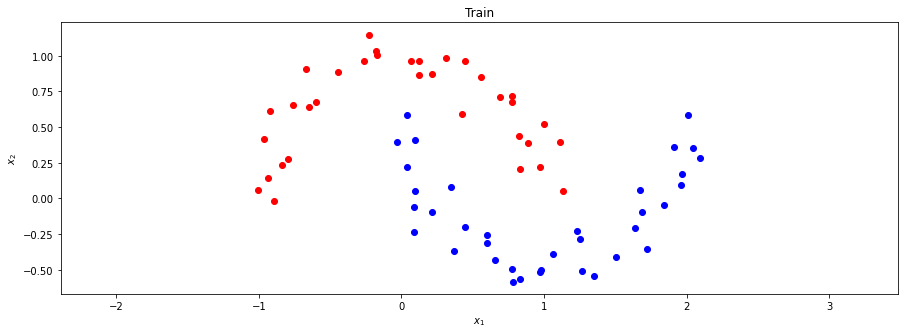

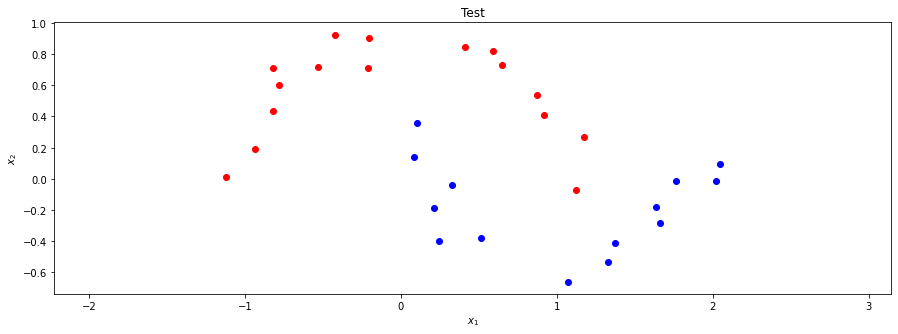

In [436]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x, y = make_moons(noise=1e-1, random_state=seed)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train'); plt.show()
plot_dataset_clas(x_te, y_te)
plt.title('Test'); plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `sklearn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results. If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [437]:
import time

C = 1
gamma = 'scale'

model_my = MySVC(C=C, gamma=gamma)
model_sk = SVC(C=C, gamma=gamma)

# Creamos un nuevo modelo con diferente tolerancia para observar los resultados
model_my_tol = MySVC(C=C, gamma=gamma, tol = 8)
# Creamos un nuevo modelo con diferente numero de iteraciones para observar los resultados
model_my_it = MySVC(C=C, gamma=gamma, tol = 00000.1 ,max_iter = 1000)

In [438]:
# Training of the models (complete).
t = time.time()
model_my.fit(x_tr, y_tr)
t_f = time.time()

t_sk = time.time()
model_sk.fit(x_tr, y_tr)
t_f_sk = time.time()

print("Time to fit for the my model: ", t_f - t)
print("Time to fit for the sk model: ", t_f_sk - t_sk , "\n")

# Entrenamos el modelo con diferente tolerancia
t_t = time.time()
model_my_tol.fit(x_tr, y_tr)
t_t_f = time.time()
print("Time to fit for the my tolerance model: ", t_t_f - t_t, "\n")

# Entrenamos el modelo con diferente numero de iteracioens
t_it = time.time()
model_my_it.fit(x_tr, y_tr)
t_it_f = time.time()
print("Time to fit for the my iterance model: ", t_it_f - t_it, "\n")

Time to fit for the my model:  0.8620760440826416
Time to fit for the sk model:  0.0007016658782958984 

Time to fit for the my tolerance model:  0.015784263610839844 

Time to fit for the my iterance model:  0.5279011726379395 



In [439]:
# Comparative of the predicted scores (complete).
scores_model_my = model_my.decision_function(x_te)
scores_model_sk = model_sk.decision_function(x_te)

print("Mean Squared Error: ", mean_squared_error(scores_model_my, scores_model_sk), "\n")

# Generamos los scores para el modelo con diferente tolerancia
scores_model_my_tol = model_my_tol.decision_function(x_te)
print("Mean Squared Error for the tolerance model: ", mean_squared_error(scores_model_my_tol, scores_model_sk), "\n")
# Generamos los scores para el modelo con diferente tolerancia
scores_model_my_it = model_my_it.decision_function(x_te)
print("Mean Squared Error for the iterance model: ", mean_squared_error(scores_model_my_it, scores_model_sk), "\n")

Mean Squared Error:  0.036188233811005895 

Mean Squared Error for the tolerance model:  29.815954405059465 

Mean Squared Error for the iterance model:  0.027708688871403226 



In [440]:
# Comparative of the predicted classes (complete).
predictedy_model_my = model_my.predict(x_te)
predictedy_model_sk = model_sk.predict(x_te)

# Filtering the clases
my_predict = np.argwhere(predictedy_model_my > 0)
sk_predict = np.argwhere(predictedy_model_sk > 0)

#print("\n My predict: ", predictedy_model_my)
print("My number of ones predict: ", np.size(my_predict))
#print(" Sk predict: ", predictedy_model_sk)
print("Sk number of ones predict: ", np.size(sk_predict))
print("% Of equal one clasess predicted (my, sk): ", np.size(my_predict)/np.size(sk_predict) * 100, "\n")

# Predecimos los resultados del modelo con la tolerancia variada
predictedy_model_my_tol = model_my_tol.predict(x_te)
my_predict_tol = np.argwhere(predictedy_model_my_tol > 0)
print("My tolerance number of ones predict: ", np.size(my_predict_tol))
print("% Of equal one clasess predicted (tol, sk): ", np.size(my_predict_tol)/np.size(sk_predict) * 100, "\n")
# Predecimos los resultados del modelo con diferente numero de iteraciones
predictedy_model_my_it = model_my_it.predict(x_te)
my_predict_it = np.argwhere(predictedy_model_my_it > 0)
print("My tolerance number of ones predict: ", np.size(my_predict_it))
print("% Of equal one clasess predicted (tol, sk): ", np.size(my_predict_it)/np.size(sk_predict) * 100, "\n")


My number of ones predict:  15
Sk number of ones predict:  15
% Of equal one clasess predicted (my, sk):  100.0 

My tolerance number of ones predict:  14
% Of equal one clasess predicted (tol, sk):  93.33333333333333 

My tolerance number of ones predict:  15
% Of equal one clasess predicted (tol, sk):  100.0 



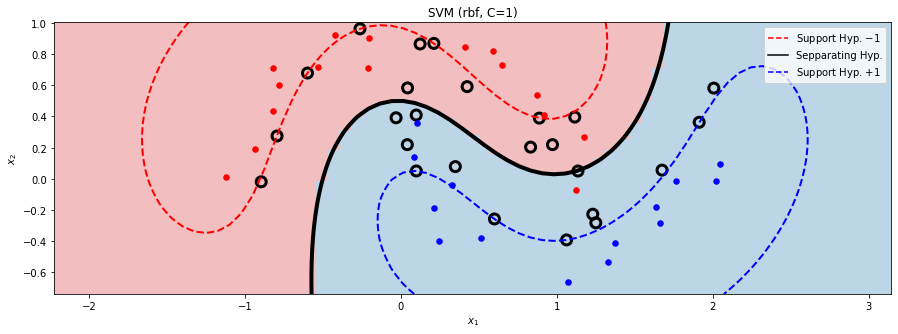

In [441]:
plot_svc(x_te, y_te, model_sk)

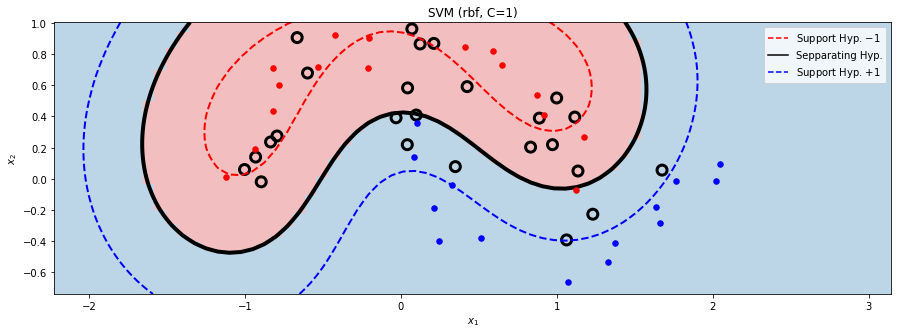

In [442]:
plot_svc(x_te, y_te, model_my)

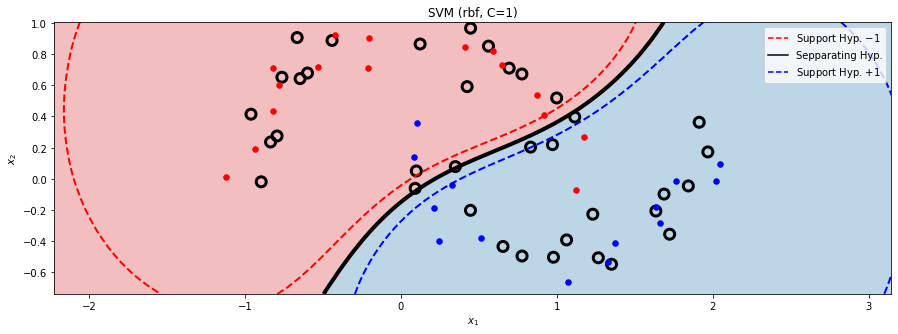

In [443]:
# Gráfica del modelo con una toleracia superior
plot_svc(x_te, y_te, model_my_tol)

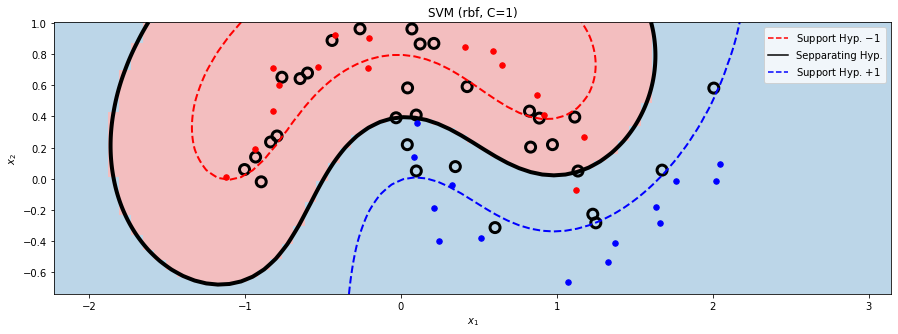

In [444]:
# Gráfica del modelo con numero de iteraciones superior
plot_svc(x_te, y_te, model_my_it)

# Comparing the outputs

De las salidas obtenidas, se observa que el código del modelo svm de sklearn es mucho mas rápido que el que hemos creado. Esto se debe a los bucles utilizados.

De igual manera, se ve que el score de ambos se diferencia aproximadamente en 0,02, lo que produce que nuestro modelo amplifique la forma de judia para una clase, otorgando una mayor cantidad de espacio para una clase de la que no hay puntos. Esto infiere que nuestro modelo se centra en agrupar el area de una de las clases y dejarle el resto de espacio al resto. Esto viene dado por la diferencia entre los hiperplanos utilizados.

Aun así, se comprueba que nuestro modelo es completamente válido, obteniendo un 100% de similitud a los resultados que obtiene el modelo de sklearn. Ambos resultados realizan las mismas predicciones para el data set otorgado con el training realizado. 

### Variating the tolerance

Al varial la tolerancia y así el numero de iteraciones, se observa que el resultado empeora, aunque el tiempo de entrenamiento sea inferior (devido al menor numero de iteraciones en el bucle de entrenamiento por la condición de parada).

Hay una gran distancia en el calculo de resultados, del 0,02 observado a 0,5 aproximado. 
Esto se refleja en que las clases predichas pasan a ser diferentes en nuestro modelo y el de sklearn. Obteniendo peores resultados a la hora de clasificar las clases, aunque no siempre.

Es decir, cuanto mas se incremente la tolerancia o se disminuya el numero iteraciones, el modelo obtenido sera peor. Por el contrario, cuanta mas veces se itere, mejor se hara. Vamos a comprobarlo.

### Variating the iteration number

Efectivamente, este modelo tarda mas en entrenarse pero se puede observar una gráfica mas similar a la del modelo sklearn y un error aproximadamente reducido a la mitad sobre nuentro primer modelo. 

Obviamente los resutlados obtenidos son iguales a los de sklearn ya que mejora la clasificación de nuentro primer modelo, la cual ya daba una concordancia del 100% en la predicción de clases, comparanda con la de sklearn. 

## Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

### Vectores de soporte
Los vectores de soporte son los vectores que cumplen que: a > 0.
Por lo tanto se seleccionan esos vectores de la matriz de entrada X, con los índices que cumplen que:
a > 0.

In [445]:
# Extraction of the lists (complete).
# Support Vectors
print("Nº of Support Vectors: ", np.shape(model_my.support_vectors_)[0], "\n\nList of vecotrs: \n", model_my.support_vectors_)

Nº of Support Vectors:  26 

List of vecotrs: 
 [[-0.7952664   0.2746645 ]
 [ 0.9720389   0.21902698]
 [ 0.42448524  0.59130712]
 [ 1.06252195 -0.39226767]
 [-0.66625776  0.90611844]
 [ 0.06999164  0.96156857]
 [ 0.88775478  0.38926482]
 [ 1.23082636 -0.22735139]
 [ 1.115151    0.39583904]
 [ 0.12278879  0.8649236 ]
 [ 1.13567114  0.04975262]
 [-0.22651016  1.14840109]
 [-0.8367634   0.23609495]
 [ 1.67526518  0.05558455]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [ 0.9989572   0.51851166]
 [ 0.0423632   0.58312272]
 [-0.03147581  0.39140976]
 [-0.93271959  0.13940703]
 [ 0.04062784  0.21890576]
 [ 0.83174596  0.20326404]
 [ 0.09781582  0.4090848 ]
 [-1.00391996  0.05940276]
 [-0.89675203 -0.01943427]
 [ 0.34875151  0.07811214]]


### Clasificación de Puntos
Para saber si los puntos están clasificados correctamente, simplemente necesitamos comprobar que la predicción hecha es igual a la clase que nos dan como entrada de datos.

Al compara podemos observar que generalmente existen 2 puntos mal clasificados y 68 bien clasificados.

In [490]:
# Points Clasification 
''' The points well classified are the ones with the predicct class = to the assigned class'''
train_predicted_model = model_my.predict(x_tr)

# print("\n",train_predicted_model ,"\n", y_tr, "\n")
well = 0
wrong = 0

print("For a total of: ", np.shape(x_tr)[0], "\n\nEstos son los resultados: ")

for i in range(np.shape(train_predicted_model)[0]):
    if(train_predicted_model[i] == y_tr[i]):
        well_classified = np.append(well_classified, x_tr[i])
        well += 1
    else:
        wrong_classified = np.append(wrong_classified, x_tr[i])
        wrong += 1

print("\t- Well clasificated points: ", well)
#print("\n", well_classified)
print("\t- Wrong clasificated points: ", wrong)
#print("\n", wrong_classified)

For a total of:  70 

Estos son los resultados: 
	- Well clasificated points:  69
	- Wrong clasificated points:  1


### Puntos posicionados en el hyperplano

Estos puntos cumplen la condición de que los coeficientes alfa están entre 0 y C, es decir: 0 < a < C 

In [491]:
# Points over Hyperplane
print("\nNº de puntos en el Hyperplano: ", np.shape(model_my.hyperplane_points)[0], "\n\nLista de los puntos: \n", model_my.hyperplane_points, "\n")


Nº de puntos en el Hyperplano:  0 

Lista de los puntos: 
 [] 



### Puntos posicionados en el lado equivocado del hyperplano

Estos puntos cumplen la condición de que los coeficientes alfa son igual a C, es decir: a = C

In [528]:
# Points on the wrong side of the hyperplane
print("Nº de Puntos en el lado incorrecto del Hyperplano: ", np.shape(model_my.wrong_hyperplane)[0] , "\n\nLista de Puntos: \n", model_my.wrong_hyperplane,"\n")
# ...
w_hyp = x_tr[np.argwhere(model_my.a == model_my.C).flatten()]
well_other_hyp = np.intersect1d(w_hyp.reshape(-1), well_classified.reshape(-1))

well_other_hyp = np.reshape(well_other_hyp, (int(np.size(well_other_hyp)/2), -1))
print("Nª de Puntos en el lado incorrecto del Hyperplano pero bien clasificados: ", np.shape(well_other_hyp)[0], "\n\nLista de Puntos: \n", well_other_hyp,"\n")

Nº de Puntos en el lado incorrecto del Hyperplano:  13 

Lista de Puntos: 
 [[ 0.9720389   0.21902698]
 [ 0.42448524  0.59130712]
 [ 1.23082636 -0.22735139]
 [ 1.115151    0.39583904]
 [ 1.13567114  0.04975262]
 [-0.22651016  1.14840109]
 [ 0.0423632   0.58312272]
 [-0.03147581  0.39140976]
 [ 0.04062784  0.21890576]
 [ 0.83174596  0.20326404]
 [ 0.09781582  0.4090848 ]
 [-0.89675203 -0.01943427]
 [ 0.34875151  0.07811214]] 

Nª de Puntos en el lado incorrecto del Hyperplano pero bien clasificados:  12 

Lista de Puntos: 
 [[-0.89675203 -0.22735139]
 [-0.22651016 -0.03147581]
 [-0.01943427  0.04062784]
 [ 0.04975262  0.07811214]
 [ 0.09781582  0.20326404]
 [ 0.21890576  0.21902698]
 [ 0.34875151  0.39140976]
 [ 0.39583904  0.4090848 ]
 [ 0.42448524  0.59130712]
 [ 0.83174596  0.9720389 ]
 [ 1.115151    1.13567114]
 [ 1.14840109  1.23082636]] 



# Gráfica

El hyperplano que separa ambas clases es la linea negra apreciable, y los hyperplano de soporte son las lineas discontinuas. Estan lineas mantienen el valor del hyperplano +1/-1.

Los puntos mal clasificado se rapidamente. Estos puntos son los que tienen un color 'a', pero están posicionados en el plano del otro color 'r'

En esta gráfica podemos observar los resultados. 
Los puntos situados justamente encima de las lineas discontinuas corresponderían a los puntos en el hyperplano

Los puntos que están en el lado incorrecto del hyperplano son los puntos que se pueden observar entre las dos lineas discontinuas o entre planos de sopporte.

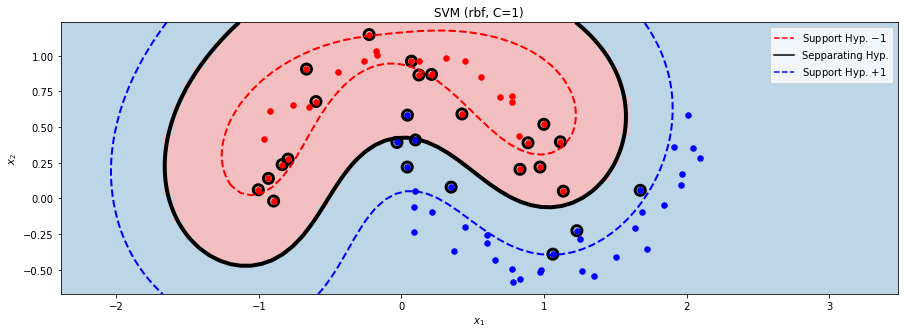

In [450]:
plot_svc(x_tr, y_tr, model_my)